In [ ]:
# GOALS: Adapt from MATLAB:

# % Convert ROI centerXY (in degrees) to pixel coordinates using TIF metadata

# function pixel_coords = convertCenterXYToPixels(centerXY_deg, pixelToRefTransform, imgSize)

# % Convert ROI centerXY (in degrees) to pixel coordinates using TIF metadata
# %
# % Inputs:
# %   centerXY_deg        - Nx2 array of ROI centers in optical degrees
# %   pixelToRefTransform - 3x3 matrix from TIF metadata (pixel to ref transform)
# %   imgSize             - [width, height] in pixels (default [512 512])
# %
# % Output:
# %   pixel_coords        - Nx2 array of 1-based pixel coordinates

#     if nargin < 3
#         imgSize = [512 512];
#     end

#     % Invert the transform to go ref → pixel
#     refToPixel = inv(pixelToRefTransform);

#     % Convert to homogeneous coordinates
#     homogXY = [centerXY_deg, ones(size(centerXY_deg,1),1)]';

#     % Apply transform
#     pixelXY = refToPixel * homogXY;
#     pixelXY = pixelXY(1:2, :)';

#     % Clip and round to image bounds
#     pixelX = min(max(round(pixelXY(:,1)), 0), imgSize(1)-1) + 1;
#     pixelY = min(max(round(pixelXY(:,2)), 0), imgSize(2)-1) + 1;

#     pixel_coords = [pixelX, pixelY];

# end

# Example ouput from Matlab:
    
#     Filtered XY coordinates (points only, no pauses):
#    -2.1346    1.7622
#     1.7418    1.0315
#     2.7213    2.0731
#     0.6380    0.2541
#     1.3117    0.1712
#     0.1612   -0.7616
#    -0.4296   -0.1708
#     0.1508    0.2023
#     1.4257    2.2960
#    -0.1912   -3.5186

# Filtered Z positions (points only, no pauses):
#   -43.7000  -38.7000  -38.7000  -38.7000  -33.7000    6.3000    6.3000    6.3000   51.3000   54.7000

# Extracted Z_min: -73.7 µm
# Extracted Z_max: 66.3 µm
# Computed number of slices: 29
# Closest matching Z slice indices for validZs:
#      7     8     8     8     9    17    17    17    26    27

In [2]:
# import tif file (file - single or stack; or import matrix)

import tifffile # !pip install tifffile
import numpy as np
import os

# Path to your ScanImage stack
# path = "/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham rbc velocity/data/raw/htau pointscan data for analysis/mht01_ZSAW_points/ROIA_grpA/"
path = '/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham rbc velocity/data/raw/07082025_htau_rmtbi/mht09/pointscans/'
# Option A: load entire stack into a single array
#    tif_data will have shape (num_slices, height, width)
# tif_filename = 'Zsaw_mht01_25x4x_800nm_grpA_00001.tif'
# meta_txt_filename = 'Zsaw_mht01_25x4x_800nm_grpA_manPockels_00001.meta.txt'
tif_filename = 'Zsaw_mht09_25x4x_800nm_ROIA1_00003.tif'
base_pmt_filename = 'Zsaw_mht09_25x4x_800nm_ROIA1_00005'
meta_txt_filename = base_pmt_filename + '.meta.txt'

tif_file = os.path.join(
    path, 
    tif_filename
)

tif_data = tifffile.imread(tif_file)

print(tif_data.shape)


(33, 2, 512, 512)


Channel 1 shape: (512, 512, 33)
Channel 2 shape: (512, 512, 33)


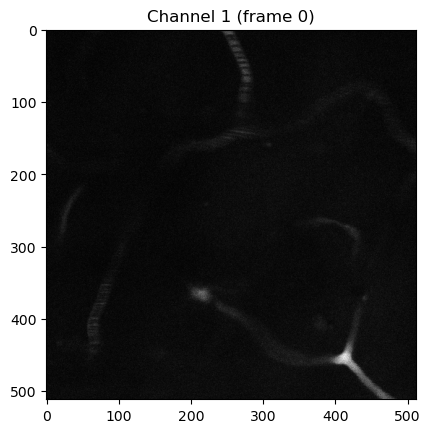

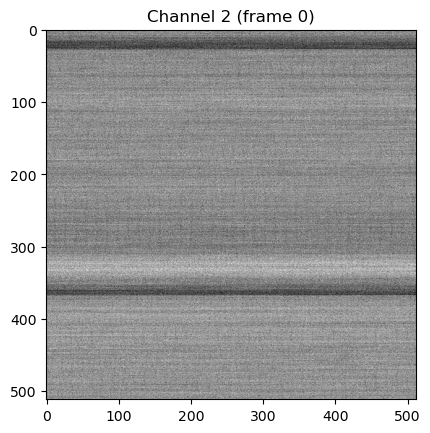

In [3]:
# Assume channel 1 is the second one (Python 0-indexed, so index = 1)
# Extract channel 1 and reshape to (Z, Y, X)
channel_1_data = tif_data[:, 0, :, :]  # shape: (33, 512, 512)
channel_2_data = tif_data[:, 1, :, :]  # shape: (33, 512, 512)

# Transpose to (Y, X, Z) if needed for your code
channel_1_data = np.transpose(channel_1_data, (1, 2, 0))  # shape: (512, 512, 33)
channel_2_data = np.transpose(channel_2_data, (1, 2, 0))  # shape: (512, 512, 33)

print(f"Channel 1 shape: {channel_1_data.shape}")
print(f"Channel 2 shape: {channel_2_data.shape}")

# Sanity check the channels
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(channel_1_data[:,:,5], cmap='gray')
plt.title('Channel 1 (frame 0)')
plt.show()

plt.figure()
plt.imshow(channel_2_data[:,:,5], cmap='gray')
plt.title('Channel 2 (frame 0)')
plt.show()

In [5]:
# tif_file = path + 'Zsaw_mht01_25x4x_800nm_grpA_00001.tif'
# tif_data = tifffile.imread(tif_file)
tif_data = channel_1_data
# print(tif_data.shape)

# If you prefer (height, width, num_slices), just transpose:
# (ie if its not Loaded stack with shape (512, 512, 33))
# tif_data = np.transpose(tif_data, (1, 2, 0))

print(f"Loaded stack with shape {tif_data.shape}")
print(f"Number of slices (tif_data.shape[2]): {tif_data.shape[2]}")

Loaded stack with shape (512, 512, 33)
Number of slices (tif_data.shape[2]): 33


In [7]:
# # !! ONLY WORKS FOR 1-channel data
# # ---------------------------------------------------------
# # Option B: read slice-by-slice (more control, same as your MATLAB loop)
# with tifffile.TiffFile(tif_file) as tif:
#     num_slices = len(tif.pages)
#     # get image shape & dtype from first page
#     height, width = tif.pages[0].shape
#     dtype = tif.pages[0].dtype
    
#     # preallocate (h, w, z)
#     data = np.zeros((height, width, num_slices), dtype=dtype)
#     for i, page in enumerate(tif.pages):
#         data[..., i] = page.asarray()

# print(f"Slice-by-slice read into array of shape {data.shape}")
# print(f"Number of slices (num_slices): " + str(num_slices))
# print(f"Number of slices (data.shape[2]): " + str(data.shape[2]))

In [8]:
# Get TIF image resolution (px/cm) and FOV in microns (L x W)

import json
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# --- 1) Read metadata from the first page ---------------------------
# Read tif file from "import tiff file"[o] section
#tif_file = 'Zsaw_mht01_25x4x_800nm_grpA_00001.tif'

with tifffile.TiffFile(tif_file) as tif:
    page = tif.pages[0]
    tags = page.tags

    # These come in as (num, denom) tuples
    res_y_raw = tags['YResolution'].value
    res_x_raw = tags['XResolution'].value
    resolution_y = res_y_raw[0] / res_y_raw[1]
    resolution_x = res_x_raw[0] / res_x_raw[1]
    resolution_unit = tags['ResolutionUnit'].value  # 1=no unit, 2=inches, 3=cm

    # 1) Image dimensions:
    height, width = page.shape # returns (rows, cols)
    # or equivalently:
    # width  = page.image_width
    # height = page.image_length

    # ScanImage sticks its full JSON header in the Artist tag:
    image_scan_area_metadata = tags['Artist'].value

# map the TIFF spec codes to human‐readable units
unit_map = {1: 'none', 2: 'inch', 3: 'cm'}
unit_name = unit_map.get(resolution_unit, 'unknown')

print(f"Resolution: {resolution_x:.1f} px/{unit_name}, {resolution_y:.1f} px/{unit_name}")

if unit_name == 'cm':
    # physical size in cm:
    width_cm  = width  / resolution_x
    height_cm = height / resolution_y
    # convert to microns:
    width_um  = width_cm  * 1e4
    height_um = height_cm * 1e4

elif unit_name == 'inch':
    # 1 in = 2.54 cm = 25 400 μm
    width_in  = width  / resolution_x
    height_in = height / resolution_y
    width_um  = width_in  * 25400
    height_um = height_in * 25400

else:
    raise ValueError(f"Unsupported resolution unit: {resolution_unit}")

print(f"Field-of-view: {width_um:.2f}×{height_um:.2f} μm")
# NOTE from 'info' in FIJI get:
#   ResolutionUnit = Centimeter
#   XResolution = 36446.21105868775
#   YResolution = 36446.21105868775

Resolution: 34029.8 px/cm, 34029.8 px/cm
Field-of-view: 150.46×150.46 μm


In [9]:
print(image_scan_area_metadata) # this is the motherlode

{
  "RoiGroups": {
    "imagingRoiGroup": {
      "ver": 1,
      "classname": "scanimage.mroi.RoiGroup",
      "name": "Default Imaging ROI Group",
      "UserData": null,
      "roiUuid": "237CE4398C165125",
      "roiUuiduint64": 2.557169624e+18,
      "rois": {
        "ver": 1,
        "classname": "scanimage.mroi.Roi",
        "name": "Default Imaging Roi",
        "UserData": {
          "imagingSystem": "ImagingScanner",
          "fillFractionSpatial": 0.9,
          "forceSquarePixelation": 1,
          "forceSquarePixels": 1,
          "scanZoomFactor": 4,
          "scanAngleShiftFast": 0,
          "scanAngleMultiplierSlow": 1,
          "scanAngleShiftSlow": 0,
          "scanRotation": 0,
          "pixelsPerLine": 512,
          "linesPerFrame": 512
        },
        "roiUuid": "5998893DEDE43887",
        "roiUuiduint64": 6.456060965e+18,
        "zs": 0,
        "scanfields": {
          "ver": 1,
          "classname": "scanimage.mroi.scanfield.fields.RotatedRectangl

In [10]:
# Get the raw ROI center_xy points (ie scanner coords) and ROI Z-positions in microns

"""
MATLAB RESULTS for Zsaw_mht01_25x4x_800nm_grpA_00001.tif scan:
Filtered XY coordinates (points only, no pauses):
   -2.1346    1.7622
    1.7418    1.0315
    2.7213    2.0731
    0.6380    0.2541
    1.3117    0.1712
    0.1612   -0.7616
   -0.4296   -0.1708
    0.1508    0.2023
    1.4257    2.2960
   -0.1912   -3.5186

Filtered Z positions (points only, no pauses):
  -43.7000  -38.7000  -38.7000  -38.7000  -33.7000    6.3000    6.3000    6.3000   51.3000   54.7000
"""

import os
import re
import numpy as np
# meta_txt_filename = 'Zsaw_mht01_25x4x_800nm_grpA_manPockels_00001.meta.txt'

# 1) Point to your meta file
meta_file = os.path.join(
    path, 
    meta_txt_filename
)

# 2) Read the entire metadata text
with open(meta_file, 'r') as f:
    meta_text = f.read()

# 3) Extract all centerXY tokens: ["x","y"]
center_xy_tokens = re.findall(
    r'"centerXY":\s*\[\s*([-+\d.eE]+)\s*,\s*([-+\d.eE]+)\s*\]',
    meta_text
)
# Convert to float array, shape (N,2)
valid_xy = np.array([[float(x), float(y)] for x, y in center_xy_tokens])

# 4) Extract all zs tokens
zs_tokens = re.findall(
    r'"zs":\s*([-+\d.eE]+)',
    meta_text
)
valid_zs = np.array([float(z) for z in zs_tokens])

# 5) Filter out “pause” ROIs at [0,0]
mask = ~((valid_xy[:,0] == 0) & (valid_xy[:,1] == 0))
valid_xy = valid_xy[mask]
valid_zs = valid_zs[mask]

# 6) Inspect results
print("Valid XY (points only):")
print(valid_xy)
print("\nValid Zs (points only):")
print(valid_zs)


Valid XY (points only):
[[ 1.43683862 -1.26929042]
 [ 0.60791446  0.45028635]
 [ 0.52854938  1.19984542]
 [ 0.53638791 -0.7225532 ]
 [-0.04954194  1.99741542]
 [ 0.16360964 -3.12079864]
 [ 0.21879287 -1.9665495 ]
 [ 0.87639297 -1.64464736]
 [ 2.95093736  1.95820827]
 [ 3.12568424  2.66639298]
 [-3.03356849  2.98944499]
 [ 1.87742722 -1.75018071]
 [ 1.8245433  -1.03107446]
 [ 0.60745961 -0.13165205]
 [-0.7004512  -2.67355083]
 [-0.97636733 -2.1033242 ]
 [-0.99706104 -1.7572791 ]
 [-0.74873652 -0.97551673]
 [-0.52800362  0.33968347]]

Valid Zs (points only):
[ 88.2  88.2  88.2  88.2  88.2 108.2 118.2 118.2 138.2 138.2 138.2 188.2
 188.2 203.2 208.2 208.2 218.2 218.2 223.2]


In [11]:
# Convert ROI center_xy scanner-coord values to TIF-image pixel-coord values (for plotting)

import numpy as np

img_width = width
img_height = height

def convert_center_xy_to_pixels_py(center_xy_deg, pixel_to_ref, img_size):
    """
    center_xy_deg: (N,2) array of ROI centers in optical degrees
    pixel_to_ref:   3×3 matrix from TIF metadata (pixel → degree transform)
    img_size:       tuple (width, height) in pixels
    
    returns: (N,2) array of integer pixel coords (0-based)
    """
    # 1) Invert the transform to go deg → px
    ref_to_pixel = np.linalg.inv(pixel_to_ref)
    
    # 2) Make homogeneous coords: [x_deg, y_deg, 1]
    N = center_xy_deg.shape[0]
    homog = np.hstack([center_xy_deg, np.ones((N,1))])  # shape (N,3)
    
    # 3) Apply transform
    pts = (ref_to_pixel @ homog.T).T                    # (N,3)
    pixel_xy = pts[:, :2]                               # drop the 1’s column
    
    # 4) Round, clip to [0..width-1] & [0..height-1]
    px = np.round(pixel_xy[:, 0]).astype(int)
    py = np.round(pixel_xy[:, 1]).astype(int)
    px = np.clip(px, 0, img_size[0]-1)
    py = np.clip(py, 0, img_size[1]-1)
    
    return np.vstack([px, py]).T  # (N,2) array of 0-based pixels

# --- Usage example ----
# valid_xy : your (N,2) optical-degree centers
# pixel_to_ref : your 3×3 matrix
# img_width, img_height : ints

# 1. Get the JSON string from the 'Artist' tag
image_scan_area_metadata_str = tags['Artist'].value

# 2. Convert JSON string to a Python dictionary
metadata = json.loads(image_scan_area_metadata_str)

# 3. Extract the transform
transform_data = metadata["RoiGroups"]["imagingRoiGroup"]["rois"]["scanfields"]["pixelToRefTransform"]

# 4. Convert to NumPy array
pixel_to_ref_matrix = np.array(transform_data)

# (Optional) print it
print(f"pixelToRefTransform:\n{pixel_to_ref_matrix}")

pixel_coords = convert_center_xy_to_pixels_py(
    valid_xy,
    pixel_to_ref_matrix,
    (img_width, img_height)
)

print("")
print(f"XY coords:\n{pixel_coords}")

pixelToRefTransform:
[[ 0.0140625   0.         -3.60703125]
 [ 0.          0.0140625  -3.60703125]
 [ 0.          0.          1.        ]]

XY coords:
[[359 166]
 [300 289]
 [294 342]
 [295 205]
 [253 399]
 [268  35]
 [272 117]
 [319 140]
 [466 396]
 [479 446]
 [ 41 469]
 [390 132]
 [386 183]
 [300 247]
 [207  66]
 [187 107]
 [186 132]
 [203 187]
 [219 281]]


In [12]:
# Create Z-indices for TIF slices from ums locations (all using *.meta.txt)

"""
### How it works
1. **Read the metadata**  
   Load the entire ScanImage `.meta.txt` into a string.

2. **Regex extraction**  
   Use three regular expressions to pull out:
   - `Z_min`  ← `SI.hStackManager.stackZStartPos` (µm)  
   - `Z_max`  ← `SI.hStackManager.stackZEndPos`   (µm)  
   - `Z_step` ← `SI.hStackManager.stackZStepSize` (µm)  

3. **Compute number of slices**  
   Mirror MATLAB’s logic:  
   ```python
   num_slices = round((Z_max - Z_min)/Z_step) + 1
   
Notes:
*Indexing
NumPy is 0-based; to mimic MATLAB’s 1-based result, simply add 1 to each index.

*Floating-point rounding
We use round((Z_max − Z_min)/Z_step) to match MATLAB’s round before +1.

*Uniform stacks only
This assumes a bounded stack definition (constant step). If your metadata uses arbitraryZs, you’d pull that array instead.

*Error checking
You may want to verify that (num_slices − 1) * Z_step + Z_min ≈ Z_max to catch tiny floating-point drifts.

*MATLAB RESULTS for Zsaw_mht01_25x4x_800nm_grpA_00001.tif scan:
Extracted Z_min: -73.7 µm
Extracted Z_max: 66.3 µm
Computed number of slices: 29
Closest matching Z slice indices for validZs:
     7     8     8     8     9    17    17    17    26    27
"""

import re
import numpy as np

# --- 1) Read your meta .txt once --------------------------------------
with open(meta_file, 'r') as f:
    meta_text = f.read()

# --- 2) Extract Z_min, Z_max, Z_step from the header -----------------
Z_min = float(re.search(
    r"SI\.hStackManager\.stackZStartPos\s*=\s*([-+\d.eE]+)",
    meta_text
).group(1))
Z_max = float(re.search(
    r"SI\.hStackManager\.stackZEndPos\s*=\s*([-+\d.eE]+)",
    meta_text
).group(1))
Z_step = float(re.search(
    r"SI\.hStackManager\.stackZStepSize\s*=\s*([-+\d.eE]+)",
    meta_text
).group(1))

# --- 3) Compute number of slices as in MATLAB -------------------------
num_slices = int(round((Z_max - Z_min) / Z_step)) + 1

# --- 4) Build the Z_positions LUT -------------------------------------
Z_positions = np.linspace(Z_min, Z_max, num_slices)

print(f"Extracted Z_min: {Z_min} µm")
print(f"Extracted Z_max: {Z_max} µm")
print(f"Computed number of slices: {num_slices}")

# --- 5) Given your valid_zs (µm), find closest matching slice index ---
# valid_zs is your array of ROI Z-positions in µm, e.g.:
# valid_zs = np.array([-43.7, -38.7, -38.7, ..., 54.7])

# 0-based indices:
slice_idx_0 = np.array([
    np.argmin(np.abs(Z_positions - z))
    for z in valid_zs
])

# Convert to 1-based to match MATLAB’s arrayfun(...) result:
slice_idx_1 = slice_idx_0 + 1

print("Closest matching Z slice indices for valid_zs:")
print(slice_idx_1)



Extracted Z_min: 83.20000000000073 µm
Extracted Z_max: 243.2000000000007 µm
Computed number of slices: 33
Closest matching Z slice indices for valid_zs:
[ 2  2  2  2  2  6  8  8 12 12 12 22 22 25 26 26 28 28 29]


In [13]:
# ALT METHOD

# # convert Z-microns to Z-slice_number
# import re
# import numpy as np

# def parse_z_stack_info(meta_text):
#     """
#     Parse out Z-stack parameters from a ScanImage .meta.txt string.
#     Returns a dict containing:
#       - num_slices       : int
#       - stack_z_start    : float (µm)
#       - stack_z_end      : float (µm)
#       - stack_z_step     : float (µm)
#       - arbitrary_zs     : list of floats (if used)
#       - z_positions      : numpy array of length num_slices or len(arbitrary_zs)
#     """
#     info = {}
#     # patterns to look for
#     params = {
#         'num_slices':        r"SI\.hStackManager\.numSlices\s*=\s*([^\n]+)",
#         'stack_z_start':     r"SI\.hStackManager\.stackZStartPos\s*=\s*([^\n]+)",
#         'stack_z_end':       r"SI\.hStackManager\.stackZEndPos\s*=\s*([^\n]+)",
#         'stack_z_step':      r"SI\.hStackManager\.stackZStepSize\s*=\s*([^\n]+)",
#         'bounded_def':       r"SI\.hStackManager\.stackDefinition\s*=\s*'([^']+)'",
#         'arbitrary_zs':      r"SI\.hStackManager\.arbitraryZs\s*=\s*\[([^\]]*)\]"
#     }
    
#     def _to_number(s):
#         try:
#             return float(s)
#         except:
#             return s.strip("'")
    
#     # extract each
#     for key, pat in params.items():
#         m = re.search(pat, meta_text)
#         if not m:
#             continue
#         val = m.group(1).strip()
#         if key == 'arbitrary_zs':
#             # split on whitespace or semicolon
#             nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", val)
#             info[key] = [float(x) for x in nums]
#         else:
#             info[key] = _to_number(val)
    
#     # build z_positions
#     if info.get('bounded_def','') == 'bounded':
#         # uniform stack
#         n = int(info.get('num_slices', 0))
#         start = info.get('stack_z_start', 0.0)
#         step  = info.get('stack_z_step', 1.0)
#         info['z_positions'] = np.arange(n) * step + start
#     else:
#         # arbitrary Zs
#         info['z_positions'] = np.array(info.get('arbitrary_zs', []))
    
#     return info

# # --- Usage ---------------------------------------------------------
# # read your meta file
# with open(meta_file, 'r') as f:
#     meta_text = f.read()

# zinfo = parse_z_stack_info(meta_text)
# print("Parsed Z‐stack info:")
# print(f"  Number of slices: {zinfo.get('num_slices')}")
# print(f"  Z start (µm):     {zinfo.get('stack_z_start')}")
# print(f"  Z step (µm):      {zinfo.get('stack_z_step')}")
# print(f"  Z end (µm):       {zinfo.get('stack_z_end')}")
# print(f"  Z positions:      {zinfo['z_positions']}")  # array of slice→Z in µm


In [14]:
# # sanity check for new Z-indices
# zcheck = (num_slices-1) * Z_step + Z_min
# print(Z_min, Z_max)
# recompute what Z_max “should” be
zcheck = Z_min + (num_slices - 1) * Z_step

print(f"Z_min (from metadata):       {Z_min:.3f} µm")
print(f"Z_max (from metadata):       {Z_max:.3f} µm")
print(f"Z_max (recomputed check):    {zcheck:.3f} µm")
print(f"Difference (check − metadata): {zcheck - Z_max:.3e} µm")

# optional assertion to catch any drift
assert abs(zcheck - Z_max) < 1e-6, "Recomputed Z_max doesn’t match metadata!"

Z_min (from metadata):       83.200 µm
Z_max (from metadata):       243.200 µm
Z_max (recomputed check):    243.200 µm
Difference (check − metadata): 2.842e-14 µm


In [15]:
# Re-make an array of Z-values in microns where Z_min = 0, Z_max = num_slices * step_size_ums - 5

# Z_positions is your original array from Z_min…Z_max
new_z_positions = Z_positions - Z_min + 10
print("New slice Z-positions in ums: " + str(new_z_positions))

# suppose slice_idx_0 is your 0-based slice index for each ROI
z_um_for_roi = new_z_positions[slice_idx_1-1] #subtract 1 to create a "slice_idx_0" so slice numbers are Pythonic
print("New ROI Z-positions: " + str(z_um_for_roi))

New slice Z-positions in ums: [ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145.
 150. 155. 160. 165. 170.]
New ROI Z-positions: [ 15.  15.  15.  15.  15.  35.  45.  45.  65.  65.  65. 115. 115. 130.
 135. 135. 145. 145. 150.]


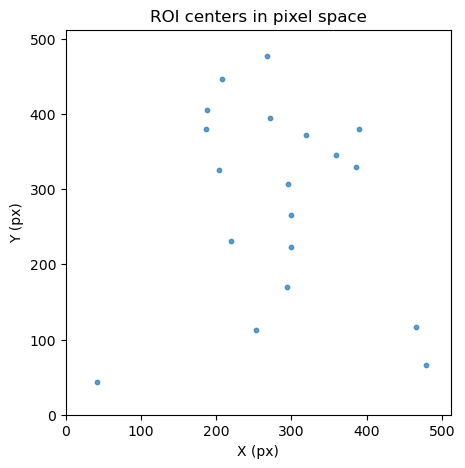

In [21]:
# --- 4) Scatter-plot (flipping Y to match MATLAB’s 1-origin bottom-up) ----
'''
*MATLAB RESULTS for Zsaw_mht01_25x4x_800nm_grpA_00001.tif scan:
*&^&**^NOTE THESE ARE OFF BY 1pixel on some??????
coords = newArray(
    105, 427, 7,
    404, 371, 8,
    479, 451, 8,
    319, 311, 8,
    371, 305, 9,
    282, 233, 17,
    237, 278, 17,
    281, 307, 17,
    380, 468, 26,
    255, 21, 27 
);
'''

plt.figure(figsize=(5,5))
plt.scatter(pixel_coords[:,0],
            img_height - pixel_coords[:,1],
            s=10, alpha=0.7)
plt.xlim(0, img_width)
plt.ylim(0, img_height)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.title('ROI centers in pixel space')
plt.show()


In [22]:
# --- 5) Print out FIJI-style coords -------------------------------
# # Print for copy-paste to FIJI macro
def print_fiji_coords(x_px, y_px, z_idx, img_width):
    """
    Mimics your printFijiCoords: prints comma-separated X,Y,Z
    (you can tweak format to drop 0-based vs 1-based indexing)
    """
    for x, y, z in zip(x_px, y_px, z_idx):
        print(f"{x:.2f}, {y:.2f}, {z}")

print_fiji_coords(pixel_coords[:,0],
                  pixel_coords[:,1],
                  z_um_for_roi,
                  img_width)

359.00, 166.00, 15.0
300.00, 289.00, 15.0
294.00, 342.00, 15.0
295.00, 205.00, 15.0
253.00, 399.00, 15.0
268.00, 35.00, 35.0
272.00, 117.00, 45.0
319.00, 140.00, 45.0
466.00, 396.00, 65.0
479.00, 446.00, 65.0
41.00, 469.00, 65.0
390.00, 132.00, 115.0
386.00, 183.00, 115.0
300.00, 247.00, 129.99999999999997
207.00, 66.00, 134.99999999999997
187.00, 107.00, 134.99999999999997
186.00, 132.00, 144.99999999999997
203.00, 187.00, 144.99999999999997
219.00, 281.00, 149.99999999999997


In [17]:
# # Print for copy-paste to FIJI macro

# # Generate FIJI macro commands including Z for each ROI

# print("// Paste the following into your FIJI macro (replace path and open command as needed)")
# for i, ((x, y), z) in enumerate(zip(pixel_coords, slice_idx_1), start=1):
#     print(f"// ROI {i}")
#     print(f"Stack.setPosition(1, {z}, 1);")   # channel=1, slice=z, frame=1
#     print(f"makePoint({x}, {y});")
#     print('roiManager("Add");')
#     print()

In [20]:
# Output XYZ coords (x, y-pixels, z-slices)

import pandas as pd

# pathtodata = "/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham rbc velocity/data/processed/mht01_processed/"
# pathtodata = "/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham rbc velocity/results/"


# Build a DataFrame
df = pd.DataFrame({
    'ROI_id': range(1,len(valid_zs)+1),
    'X_px':           pixel_coords[:, 0],
    'Y_px':           pixel_coords[:, 1],
    'Z_sliceNum':   slice_idx_1,
    'Z_motorMicrons': valid_zs,
    'Z_microns':   z_um_for_roi
})

# Save it out
# SAVE THIS BACK TO META.TXT folder
filename_base = meta_txt_filename.replace('.meta.txt','')
# csv_path = pathtodata + 'rois_' + filename_base + '.csv'
csv_path = path + 'rois_' + filename_base + '.csv'
df.to_csv(csv_path, index=False)
print(f"ROI table saved to {csv_path}")

# This CSV can be used in FIJI macro to create RoiSet ZIP file with corresponding ROIs 
#  'drawrois_from_pointscancsv.ijm'
# One application is to load ROIs, and create new lines for FWHM/leak analysis


ROI table saved to /Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham rbc velocity/data/raw/07082025_htau_rmtbi/mht09/pointscans/rois_Zsaw_mht09_25x4x_800nm_ROIA1_00005.csv


In [ ]:
# PLOTTING METHODS BELOW


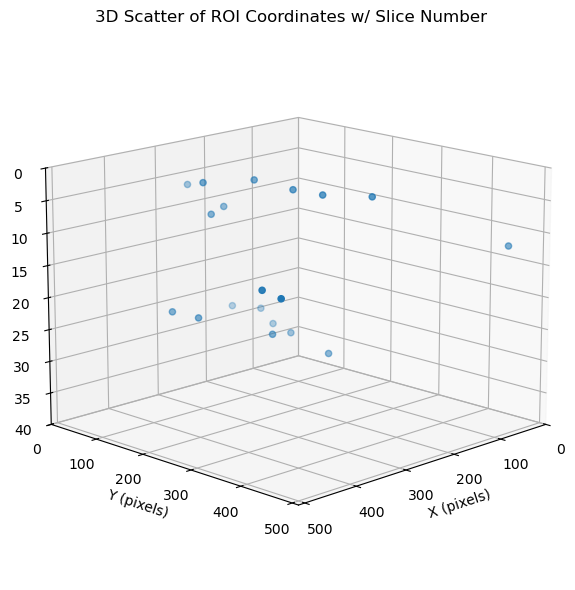

In [51]:
# plot XYZ scatter - method 1 using slice number and fixed view
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

"""
What this does

Imports the Matplotlib 3D toolkit.

Extracts your 
𝑥
x, 
𝑦
y and 
𝑧
z arrays.

Creates a 3D axes and plots each point.

Labels the axes and shows the figure.

Run it in the same cell after your ROI‐parsing code to see your ROIs in 3D space.
"""
# --- assume these already exist from your previous code ---
# pixel_coords : (N×2) NumPy array of [x_px, y_px]
# valid_zs     : (N,)    NumPy array of Z positions in µm

x = pixel_coords[:, 0]
y = pixel_coords[:, 1]

# Plot with Z_min=0 with step-size to Z-max in microns
# z = z_um_for_roi

# Plot with tiff slice#
z = slice_idx_1

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='o')
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Z (µm)')
ax.set_title('3D Scatter of ROI Coordinates w/ Slice Number')

ax.view_init(elev=15, azim=45)

# after you've created fig, ax and done ax.scatter(...)
ax.set_xlim(0, img_width)
ax.set_ylim(0, img_height)
# ax.set_zlim(0,  (num_slices-1)*Z_step)   # or fixed 200 as you like
# ax.set_zlim(0,  200)   # or fixed 200 as you like
ax.set_zlim(0,  40)
ax.invert_zaxis()

# turn off the grid lines
# ax.grid(False)

# remove the colored background panes
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# and make the figure background white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# redraw
plt.draw()

plt.tight_layout()
plt.show()

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- assume these already exist from your previous code ---
# pixel_coords : (N×2) NumPy array of [x_px, y_px]
# valid_zs     : (N,)    NumPy array of Z positions in µm

x = pixel_coords[:, 0]
y = pixel_coords[:, 1]

# Plot with Z_min=0 with step-size to Z-max in microns
z = z_um_for_roi

# Plot with tiff slice#
# z = slice_idx_1

# Define the ROI color LUT (25 distinct RGB tuples)
roi_colors = np.array([
    (0,   0,   1),     # Blue
    (1,   0,   0),     # Red
    (0,   1,   0),     # Green
    (0.5, 0.5, 1),     # Soft Blue
    (0,   0.6, 0.3),   # Sea Green
    (1,   0,   1),     # Magenta
    (0,   1,   1),     # Cyan
    (1,   0.5, 0),     # Orange
    (0.5, 1,   0),     # Lime
    (1,   0.5, 0.5),   # Pink
    (0.5, 0,   1),     # Purple
    (0,   0.5, 1),     # Light Blue
    (0.5, 0.5, 0.5),   # Gray
    (0.8, 0.2, 0),     # Dark Orange
    (0.2, 0.8, 0),     # Dark Lime
    (0,   0.8, 0.8),   # Teal
    (0.8, 0,   0.8),   # Violet
    (0.6, 0.3, 0),     # Brown
    (0.3, 0.6, 0),     # Olive Green
    (0.3, 0,   0.6),   # Dark Purple
    (0.6, 0,   0.3),   # Maroon
    (0.6, 0.6, 0),     # Mustard
    (1,   1,   0),     # Yellow
    (0.3, 0.3, 0.3),   # Dark Gray
    (0.9, 0.6, 0.2)    # Gold
])

# Assign a color for each ROI, cycling through if more than 25
n_points = pixel_coords.shape[0]
point_colors = roi_colors[np.arange(n_points) % len(roi_colors)]

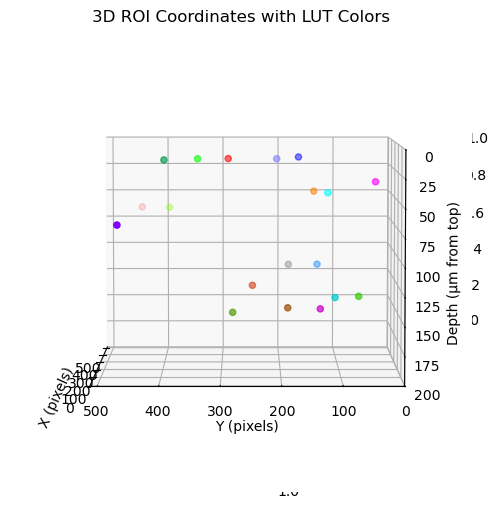

In [53]:
# Create 3D scatter - Version 1
# fig = plt.figure(figsize=(8, 6))
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    x,
    y,
    z,
    c=point_colors,
    marker='o'
)

# Label axes
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Depth (µm from top)')
ax.set_title('3D ROI Coordinates with LUT Colors')

# Adjust view for better depth perception
# ax.view_init(elev=15, azim=45)
ax.view_init(elev=5, azim=180)

# Remove grid and background panes for clarity
# ax.grid(False)
fig.patch.set_facecolor('white')
# ax.w_xaxis.set_pane_color((1, 1, 1, 0))
# ax.w_yaxis.set_pane_color((1, 1, 1, 0))
# ax.w_zaxis.set_pane_color((1, 1, 1, 0))

# after you've created fig, ax and done ax.scatter(...)
ax.set_xlim(0, img_width)
ax.set_ylim(0, img_height)
# ax.set_zlim(0,  (num_slices-1)*Z_step)   # or fixed 200 as you like
ax.set_zlim(0,  200)   # or fixed 200 as you like
# ax.set_zlim(0,  40)
ax.invert_zaxis()

# plt.tight_layout()
plt.show()

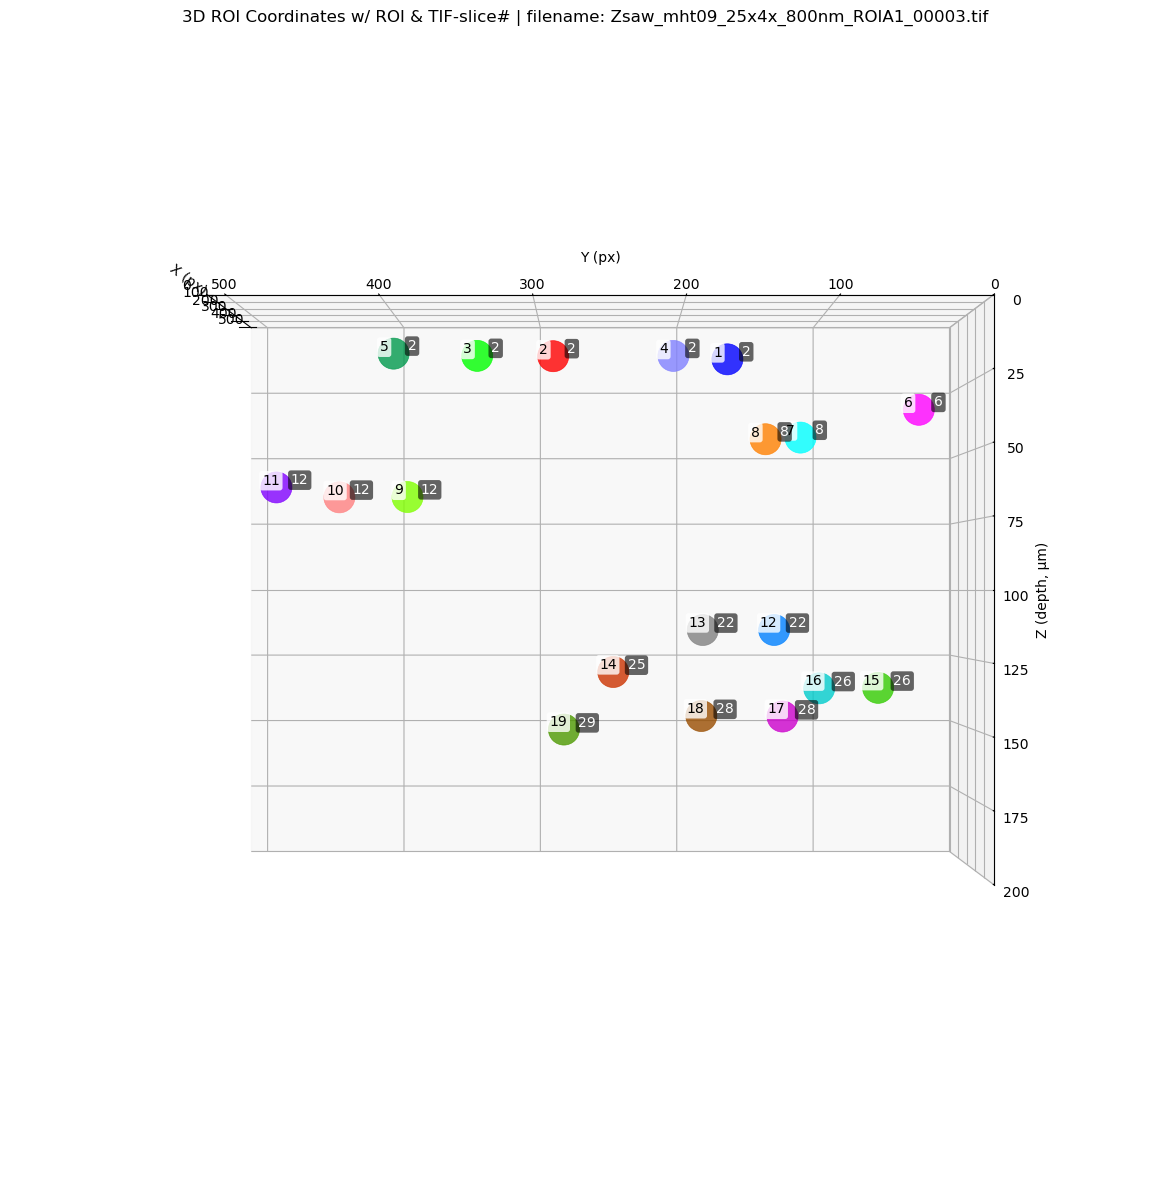

359.00, 166.00, 15.0
300.00, 289.00, 15.0
294.00, 342.00, 15.0
295.00, 205.00, 15.0
253.00, 399.00, 15.0
268.00, 35.00, 35.0
272.00, 117.00, 45.0
319.00, 140.00, 45.0
466.00, 396.00, 65.0
479.00, 446.00, 65.0
41.00, 469.00, 65.0
390.00, 132.00, 115.0
386.00, 183.00, 115.0
300.00, 247.00, 129.99999999999997
207.00, 66.00, 134.99999999999997
187.00, 107.00, 134.99999999999997
186.00, 132.00, 144.99999999999997
203.00, 187.00, 144.99999999999997
219.00, 281.00, 149.99999999999997


In [56]:
# Create 3D scatter - Version 2
# --- assume these already exist from your previous code ---
# pixel_coords : (N×2) NumPy array of [x_px, y_px]
# valid_zs     : (N,)    NumPy array of Z positions in µm

x = pixel_coords[:, 0]
y = pixel_coords[:, 1]

# Plot with Z_min=0 with step-size to Z-max in microns
z = z_um_for_roi

# Plot with tiff slice#
# z = slice_idx_1

# fig = plt.figure(figsize=(16,12))
# ax  = fig.add_subplot(111, projection='3d')
# ax.scatter(
#     x,
#     y,
#     z,
#     c=point_colors,
#     marker='o'
# )
fig = plt.figure(figsize=(16,12))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(
    x,
    y,
    z,
    c=point_colors,
    marker='o',
    s=500,           # marker area in points^2
    alpha=0.8,       # optional transparency
    linewidths=0.5   # optional edge width
)

# annotate slice numbers
# for i, s in enumerate(slice_idx_1):
#     x, y, z = pixel_coords[i,0], pixel_coords[i,1], z_um_for_roi[i]
#     ax.text(x, y, z, str(s),
#             color='black', fontsize=12,
#             horizontalalignment='left',
#             verticalalignment='bottom')
# how much to nudge (in your data's units)
dx, dy, dz = 10, 10, 0  

for i, s in enumerate(slice_idx_1):
    x, y, z = pixel_coords[i,0], pixel_coords[i,1], z_um_for_roi[i]

    ax.text(
        x + dx, 
        y + dy, 
        z + dz,
        str(i+1),
        color='black',
        fontsize=10,
        horizontalalignment='left',
        verticalalignment='bottom',
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="white",
            alpha=0.8,
            edgecolor="none"
        )
    )
for i, s in enumerate(slice_idx_1):
    x, y, z = pixel_coords[i,0], pixel_coords[i,1], z_um_for_roi[i]

    ax.text(
        x - dx, 
        y - dy, 
        z - dz,
        str(s),
        color='white',
        fontsize=10,
        horizontalalignment='left',
        verticalalignment='bottom',
        bbox=dict(
            boxstyle="round,pad=0.2",
            facecolor="black",
            alpha=0.6,
            edgecolor="none"
        )
    )


# axis labels / view / styling
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Z (depth, µm)')
ax.set_title('3D ROI Coordinates w/ ROI & TIF-slice# | filename: ' + tif_filename)
# ax.view_init(elev=25, azim=50)
ax.view_init(elev=0, azim=180)

# ax.grid(False)
fig.patch.set_facecolor('white')
# ax.w_xaxis.set_pane_color((1,1,1,0))
# ax.w_yaxis.set_pane_color((1,1,1,0))
# ax.w_zaxis.set_pane_color((1,1,1,0))

# after you've created fig, ax and done ax.scatter(...)
ax.set_xlim(0, img_width)
ax.set_ylim(0, img_height)
# ax.set_zlim(0,  (num_slices-1)*Z_step)   # or fixed 200 as you like
ax.set_zlim(0,  200)   # or fixed 200 as you like
# ax.set_zlim(0,  40)
ax.invert_zaxis()

plt.tight_layout()
plt.show()

print_fiji_coords(pixel_coords[:,0],
                  pixel_coords[:,1],
                  z_um_for_roi,
                  img_width)